In [1]:
import re
from datetime import date
import datetime
import pickle
import seaborn as sns

import requests
import pandas as pd
from datetime import datetime
import time, math
import matplotlib.pyplot as plt
sns.set()
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)
sns.set(style="ticks")

#import toolboxes
from reddit_toolbox import piecewise_lin_fit, search_mentions, search_drug_pattern, function_find_pattern
# Getting data:
with open('objs.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
     data_combined_with_delta = pickle.load(f)

data_combined_with_delta['year'] = \
pd.to_datetime('12/' + pd.to_datetime(data_combined_with_delta['created_utc']).dt.year.astype(str), format='%m/%Y')

# data_combined_with_delta['year'] = data_combined_with_delta['year'].astype('int')
drug_kwrds = {'4-FA' : '4-FA|4FMP', 
              '4-MMC': '4-MMC|mephedrone | mefedron',
              '6-ABP': '6-APB| Benzofury| Benzo Fury',
              'A-PHP'  : 'alpha-PHP|α-PHP|a-php',
              'Phenibut': 'Phenibut|fenibut',

             }
trimbos = pd.read_csv('../../../corpus/trimbos/trimbos_data.csv')
trimbos['year'] = '12/' + trimbos['year'].astype(str)
trimbos['year'] = pd.to_datetime(trimbos['year'], format='%m/%Y')


,title,selftext,body,contains
0,https://3mmc.sfsdf.sfdsf.sdfsf,NaN,NaN,False
1,3mmc,NaN,NaN,True
2,3 mmc,NaN,NaN,True
3,3MmC,NaN,NaN,True
4,,3mmc,NaN,True
5,,NaN,3mmc,True
6,,NaN,4 abc,True


In [ ]:
print(pd.__version__)

In [2]:
data_combined_with_delta['year']

subreddit    id     
1P_LSD       j56fqvn   2023-12-01
             j55zgsj   2023-12-01
             j55xsbx   2023-12-01
             j55vtlh   2023-12-01
             j55q3nc   2023-12-01
                          ...    
tripreports  otqz2r    2021-12-01
             h6x7m57   2021-12-01
             h6px1cc   2021-12-01
             osohl1    2021-12-01
             h6ppewh   2021-12-01
Name: year, Length: 310422, dtype: datetime64[ns]

In [3]:
data_combined_with_delta['num_comments'].fillna(0, inplace=True)
data_combined_with_delta['upvote_ratio'].fillna(0, inplace=True)
data_combined_with_delta['ups'].fillna(0, inplace=True)
data_combined_with_delta['downs'].fillna(0, inplace=True)
data_combined_with_delta['score'].fillna(0, inplace=True)


In [4]:
def plots(drug, data_field, data_frame, trimbos_data, group_range='year_month'):
    
    data_frame[data_field+'agg'] = \
    data_frame[data_field]*data_frame['contains'].astype('float')
    
    X = data_frame[[group_range, data_field+'agg']].groupby(group_range).sum()

    output  = piecewise_lin_fit(X, data_field+'agg', number_of_breaks=12)

    output = output[output[group_range] < datetime(2022, 1, 1)]
    X = X[X.index < datetime(2022, 1, 1)]
    
    fig, ax = plt.subplots()
    ax.plot(X.index, X[data_field+'agg'], label='reddit', linewidth = 1, color='green')
    ax.plot(output[group_range], output['average'], label='moving average', \
             linewidth = 1, color='blue')
    ax.plot(output[group_range], output['pwlf'], label='pwlf', linewidth = 1.5, color='black')
    plt.xticks(rotation='vertical') 
    ax2=ax.twinx()
    ax2.plot(trimbos['year'], trimbos[drug], 
             label='trimbos', linewidth = 3, color='red')
    ax.lines[2].set_linestyle("--")
    plt.xlim(date(2012, 1, 1), date(2022, 1, 1))
    ax.legend(loc=(0.005,0.845))
    ax2.legend(loc=(0.005, 0.94))

    ax2.set(ylabel='Trimbos Drug Sample Data')
    ax.set(xlabel='Year')
    ax.set(ylabel= data_field.capitalize() +' in reddit')
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title("Trimbos Sample Data and "+ data_field +" in reddit, from 2012 to 2021, for "+ drug)
    plt.show()


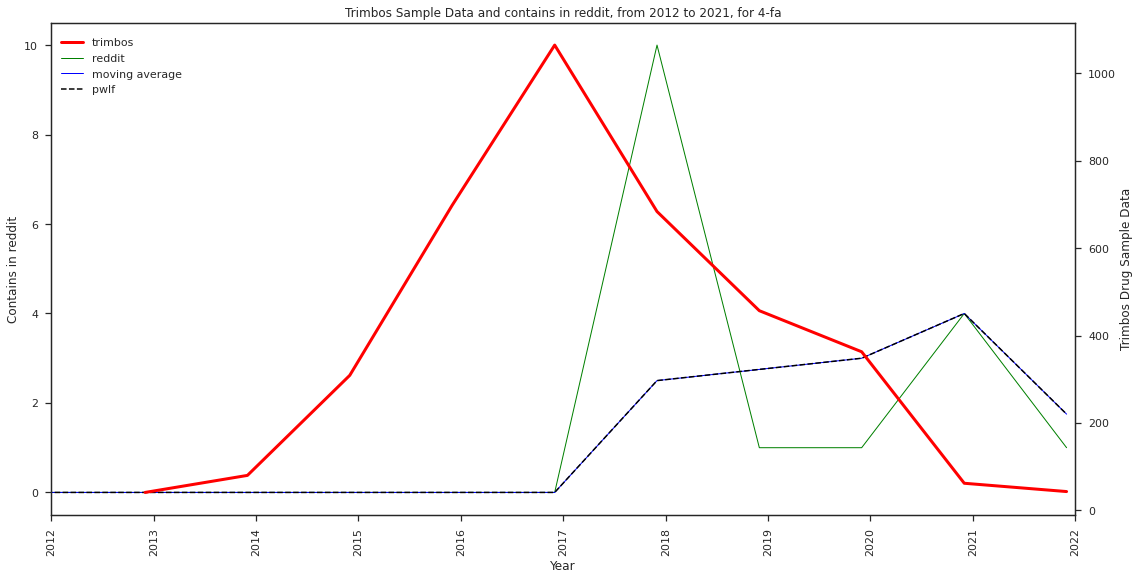

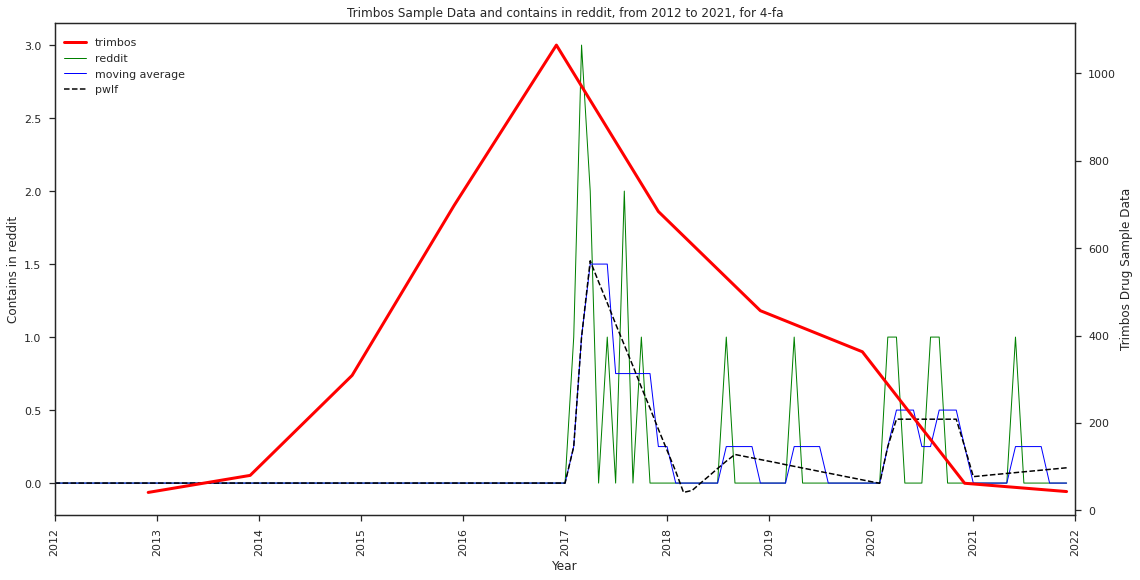

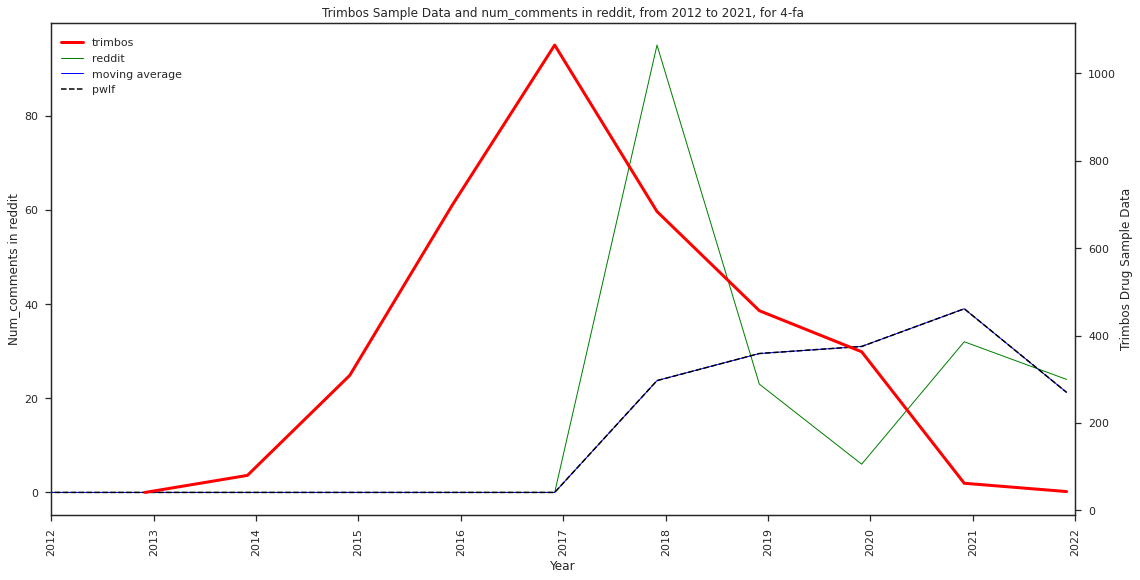

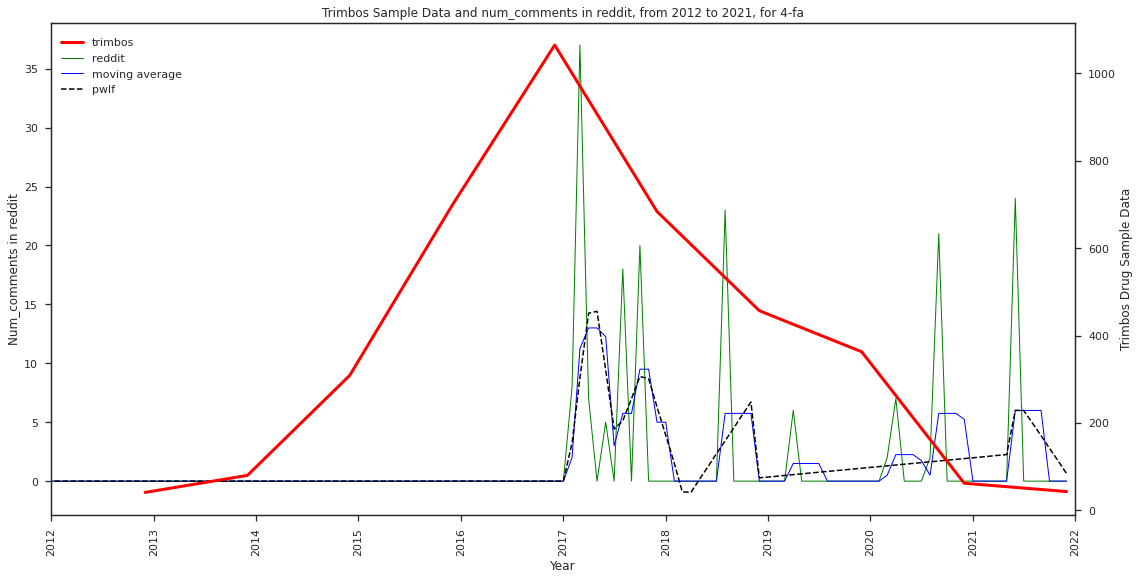

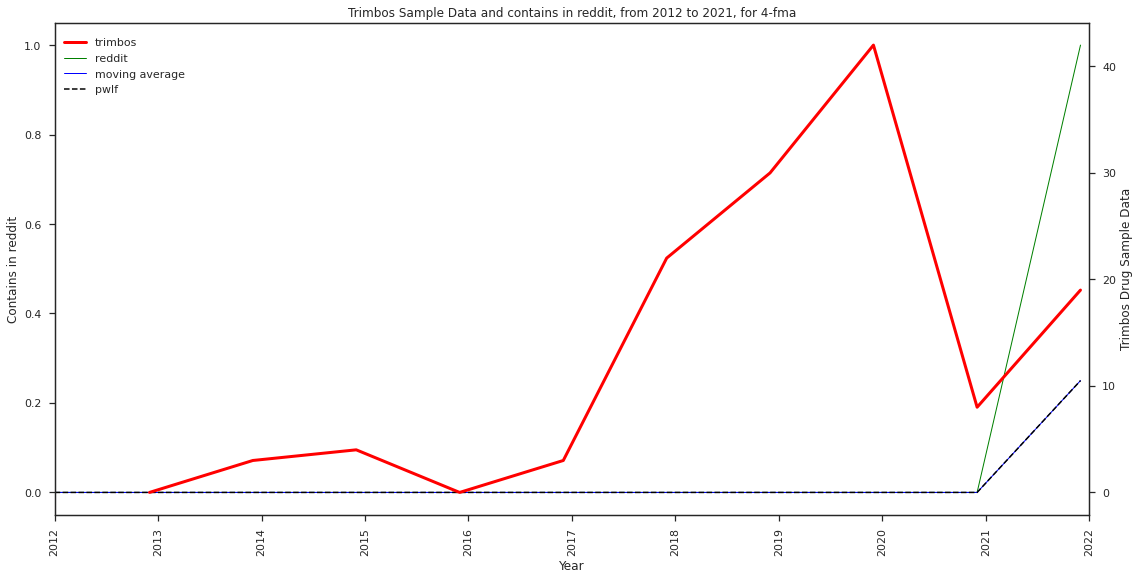

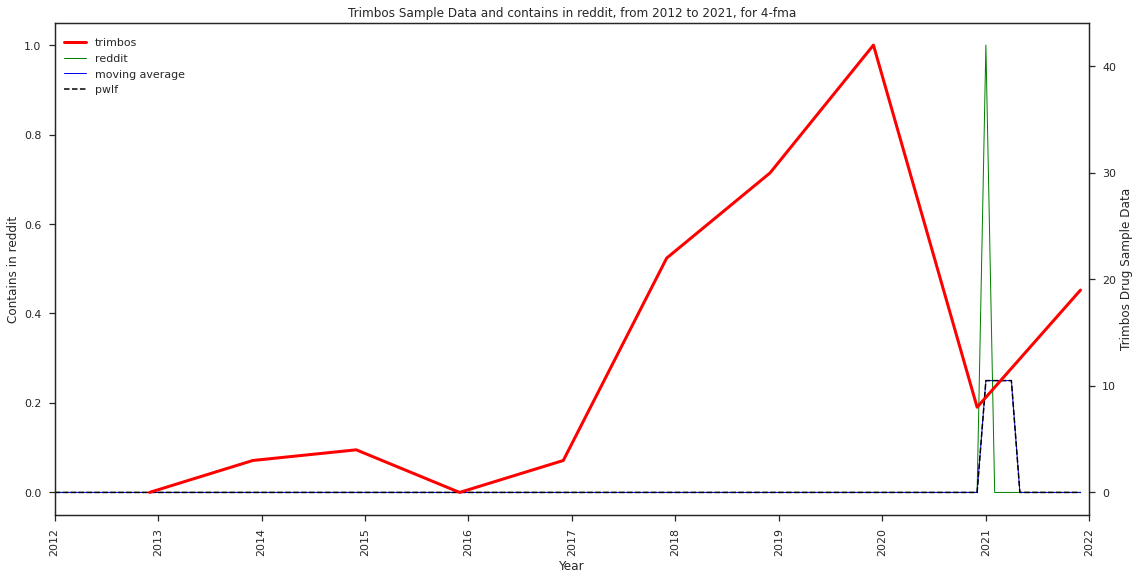

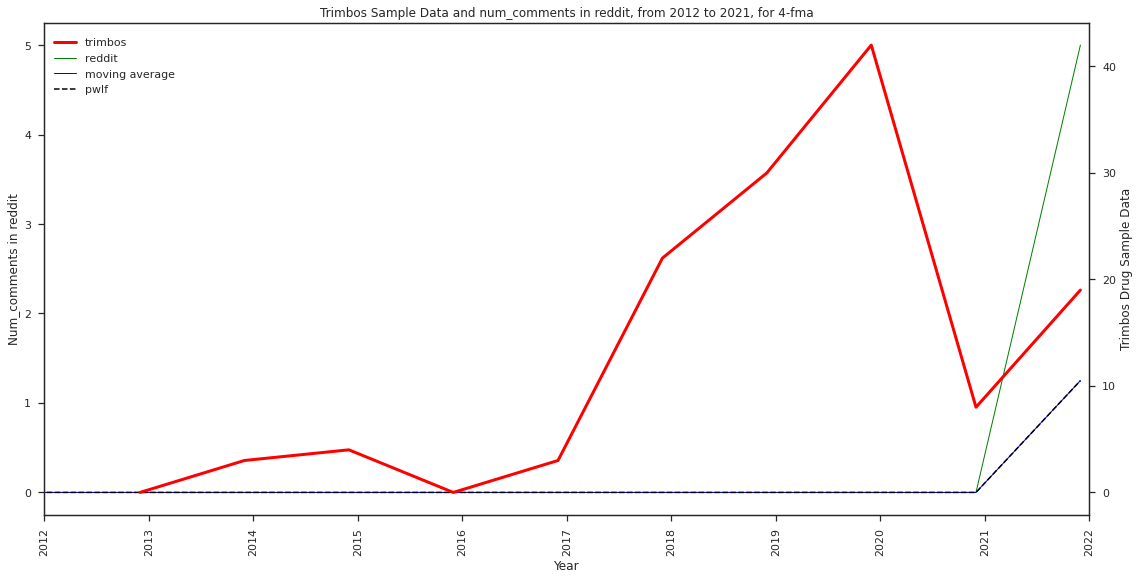

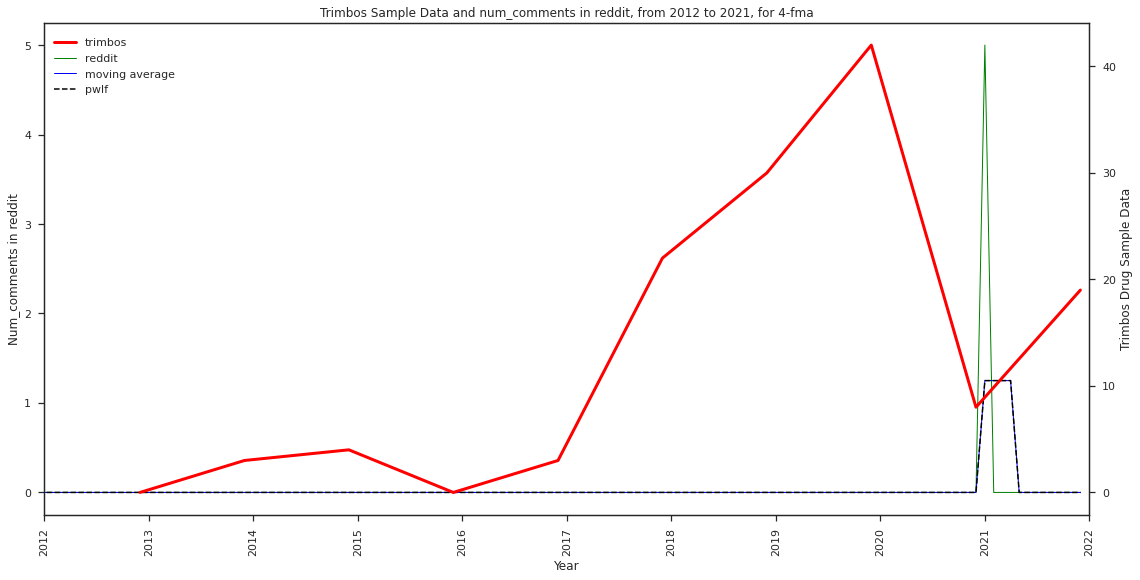

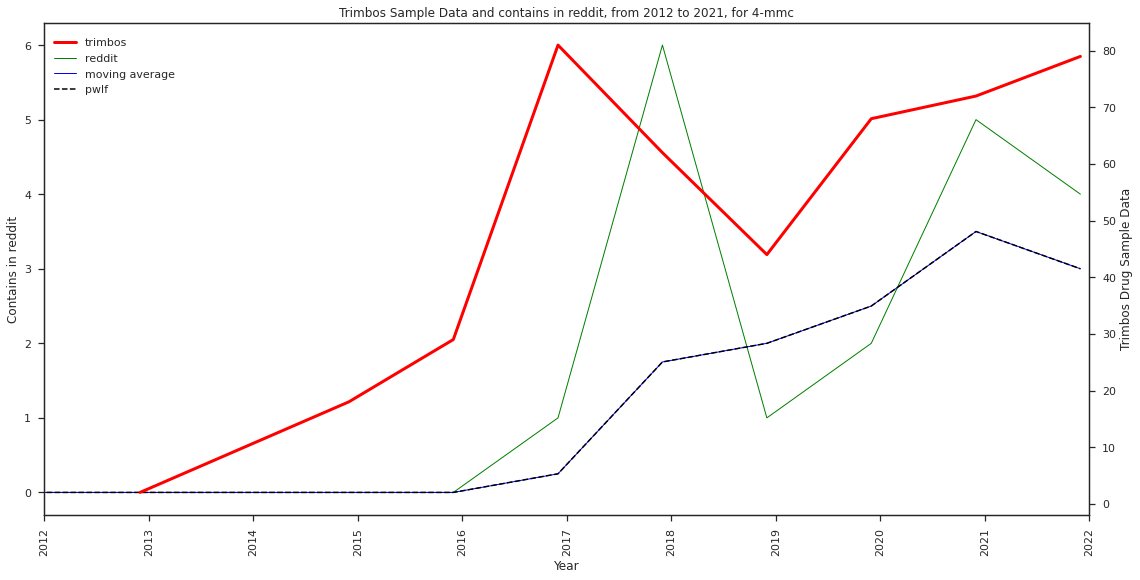

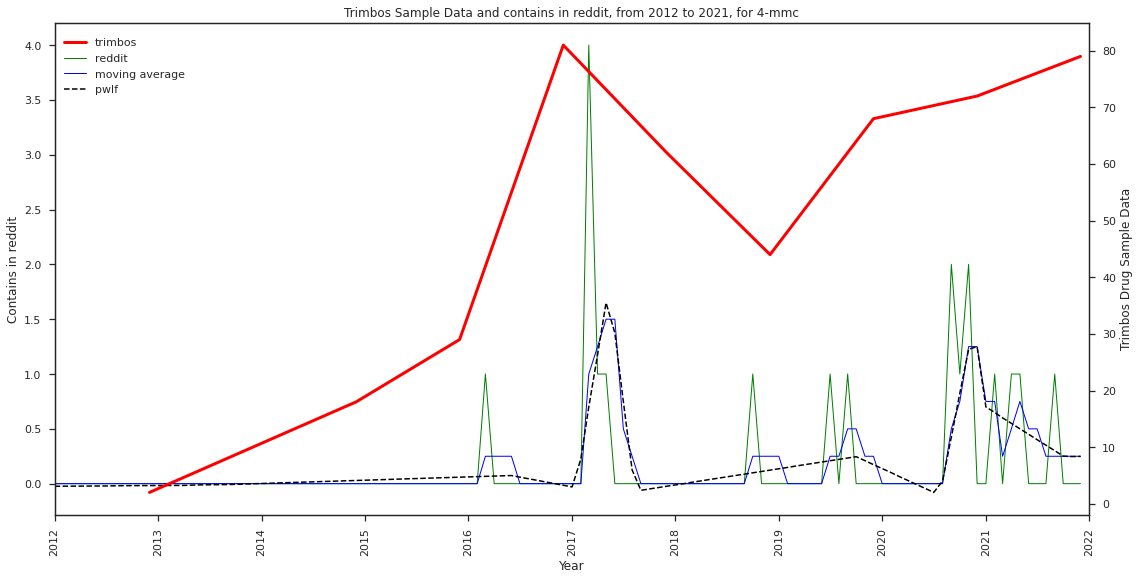

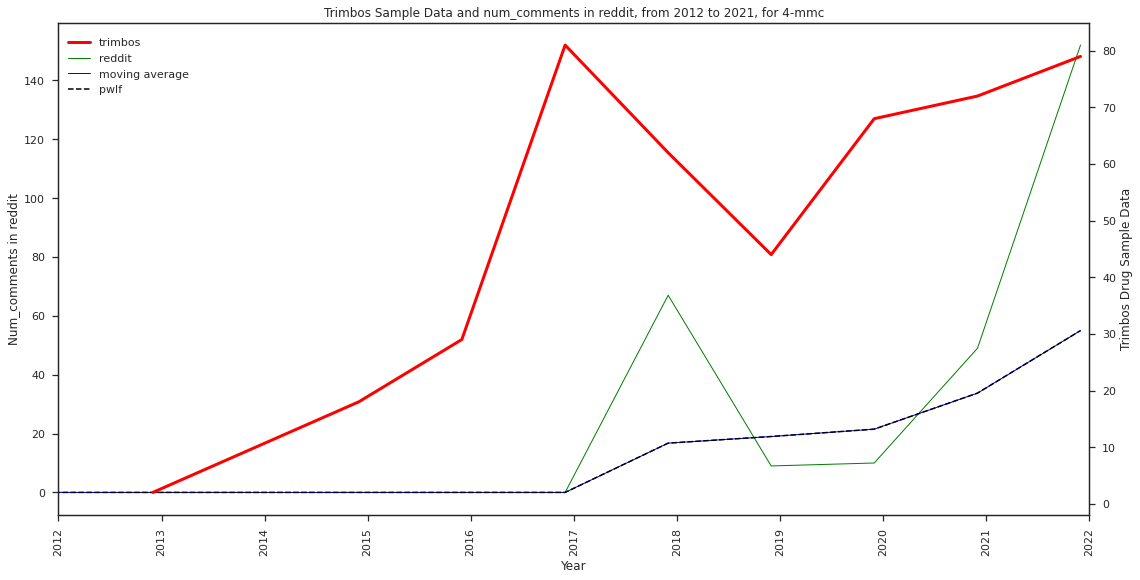

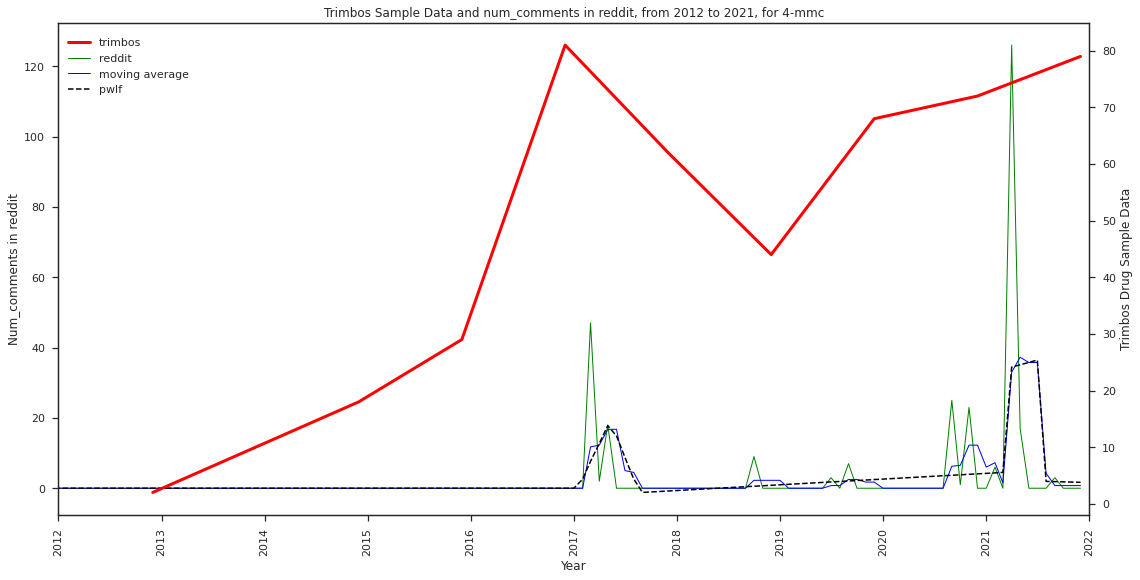

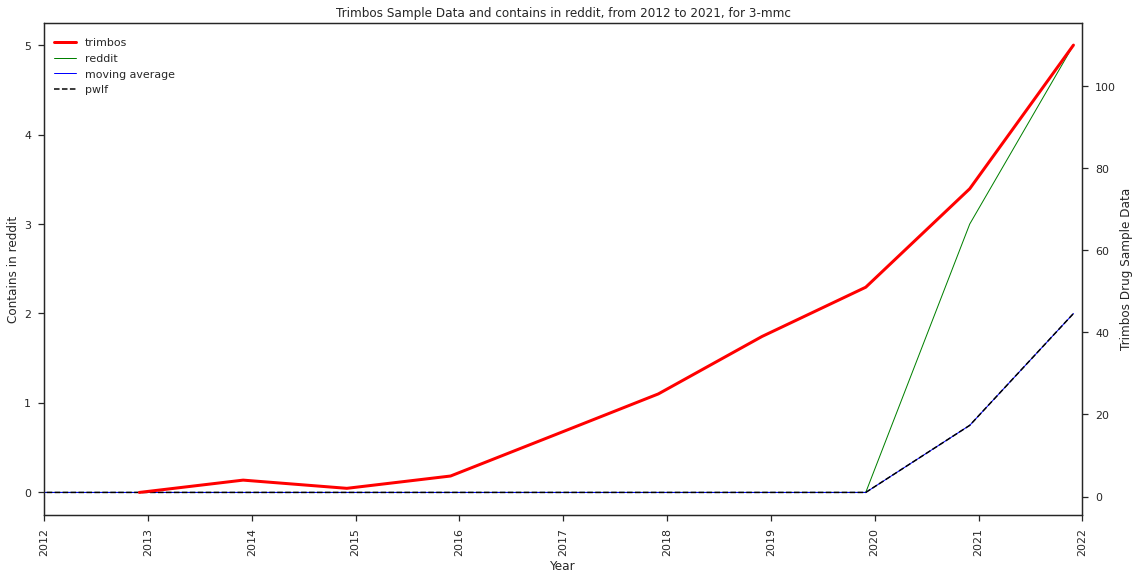

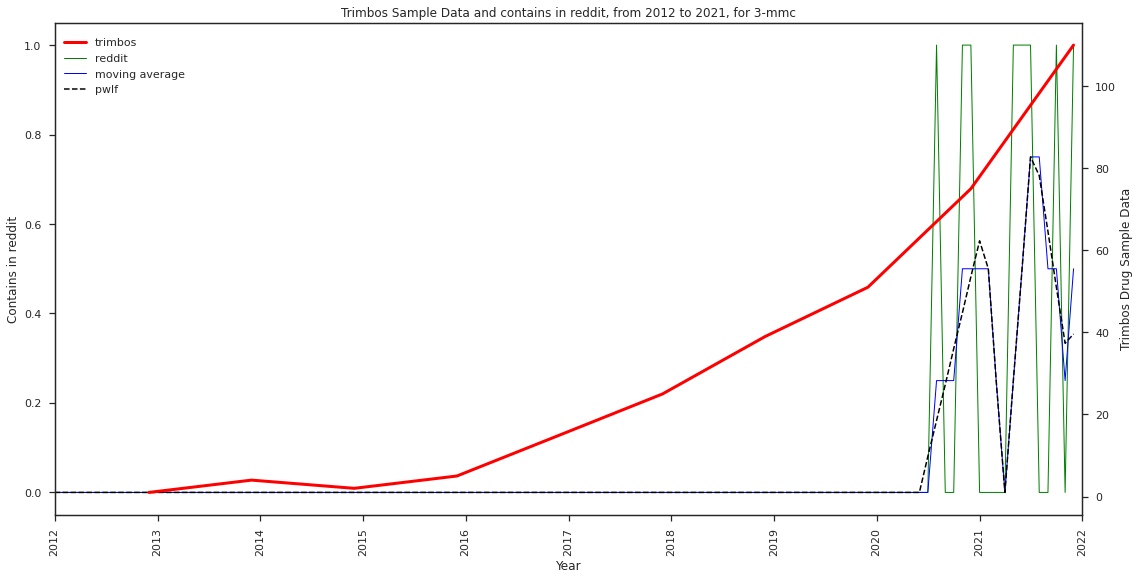

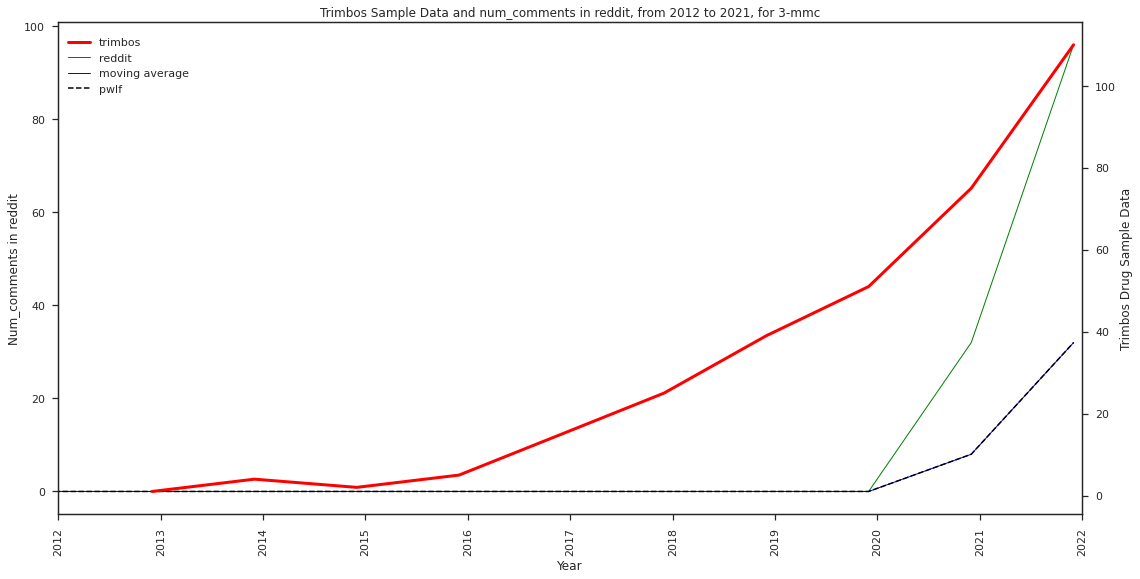

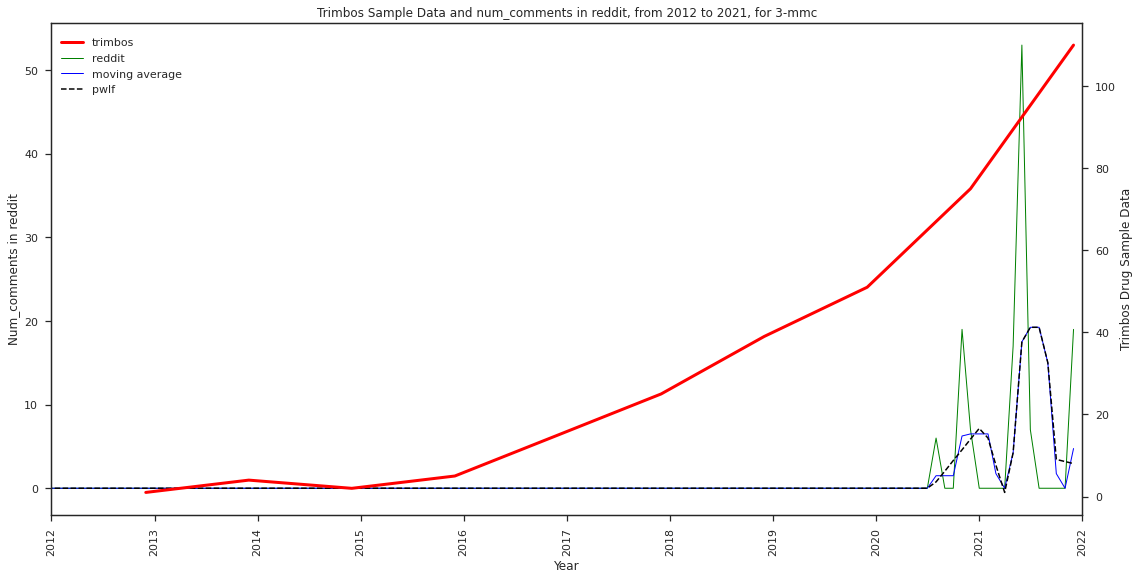

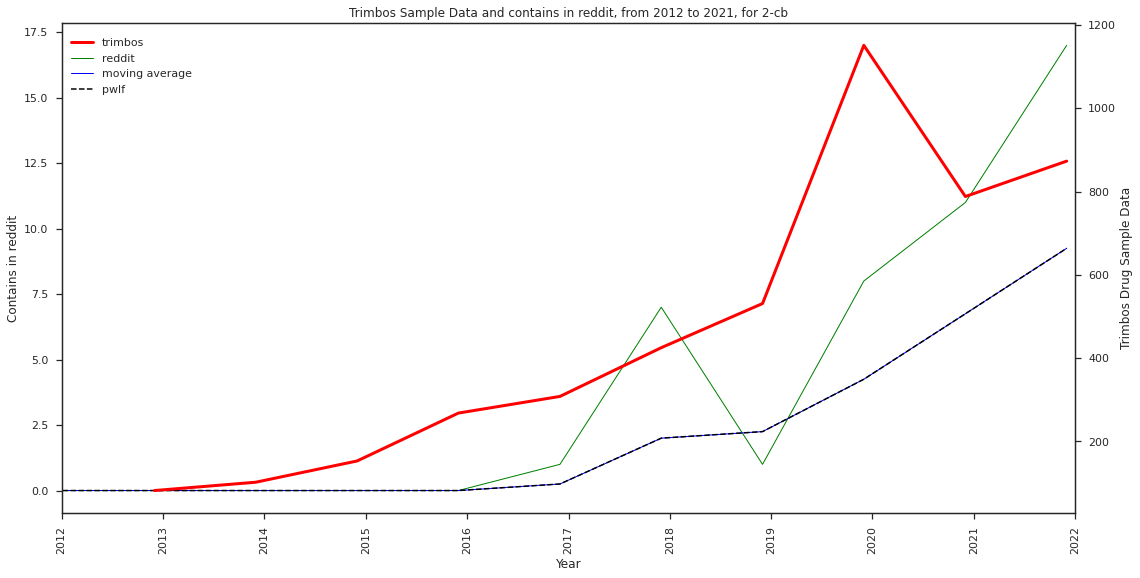

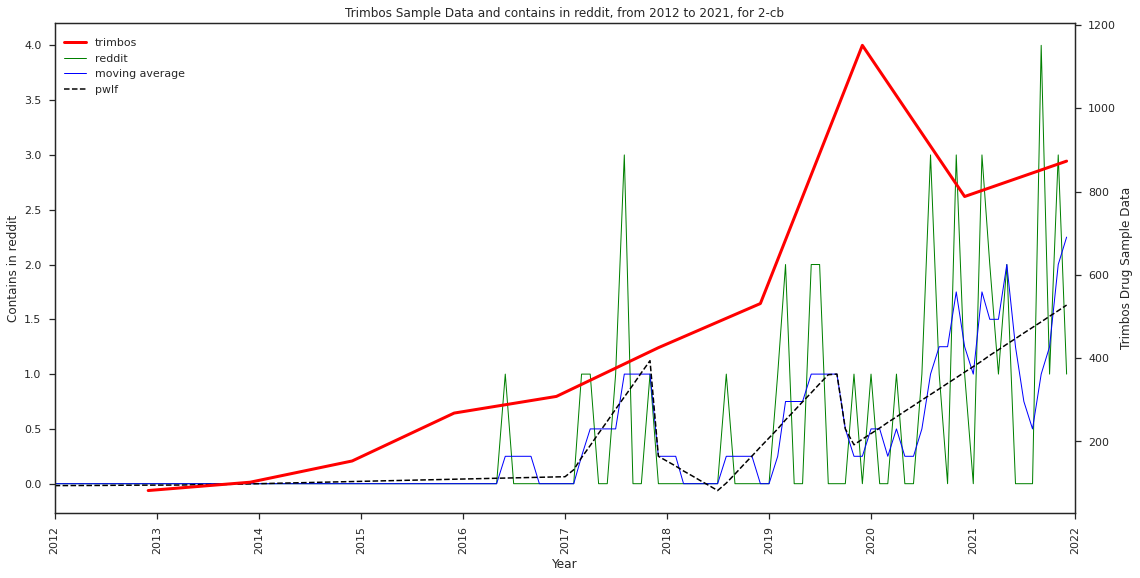

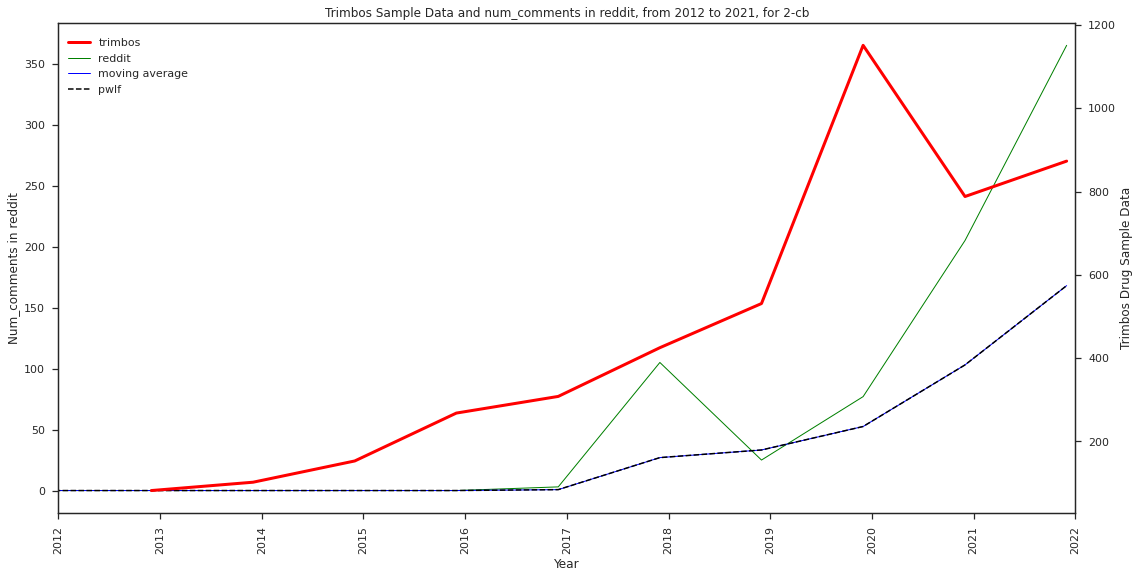

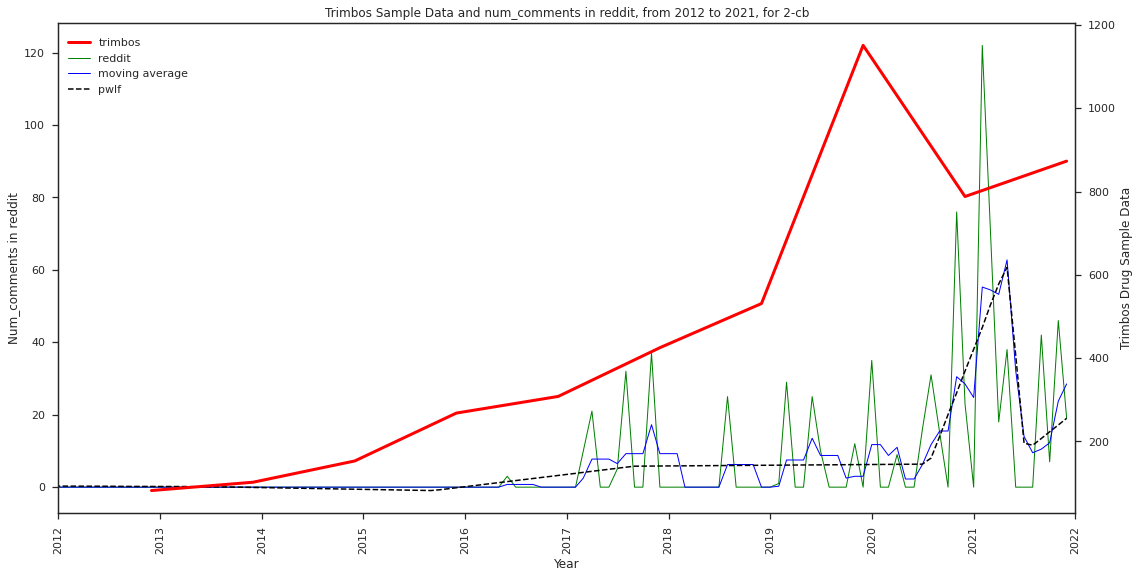

In [5]:
search_drugs = ['4-fa', '4-fma', '4-mmc', '3-mmc', '2-cb']
# search_drugs = ['4-fa']
drug_mentions = pd.DataFrame()

for i, drug in enumerate(search_drugs):

    search_mentions(data_combined_with_delta, drug_name=function_find_pattern(drug, drug_kwrds) )
    
    data_no_comments = data_combined_with_delta[data_combined_with_delta['kind']=='t3'].reset_index()
    
    data_field = 'contains'
    plots(drug, data_field, data_no_comments, trimbos, 'year')    
    plots(drug, data_field, data_no_comments, trimbos, 'year_month')    

    data_field = 'num_comments'
    plots(drug, data_field, data_no_comments, trimbos, 'year')
    plots(drug, data_field, data_no_comments, trimbos, 'year_month')

    


In [71]:
# def get_trimbos_nl_correlation(trimbos_data, reddit_data, metric='views'):
correlation_df = pd.DataFrame(columns=['drug', 'metrics', 'actual', 'rolling', 'pwlf'] )
from scipy.stats import pearsonr
pearsonr([1, 2, 3], [4, 3, 7])

for i, drug in enumerate(search_drugs):
    search_mentions(data_combined_with_delta, drug_name=function_find_pattern(drug, drug_kwrds) )
    
    data_no_comments = data_combined_with_delta[data_combined_with_delta['kind']=='t3'].reset_index()
    
    for metrics in ['contains', 'num_comments', 'ups']:
     
        field_name = metrics +'_'+drug

        data_no_comments[field_name] = data_no_comments[metrics]*data_no_comments['contains'].astype('float')

        metric_data = data_no_comments[['year', field_name]].groupby('year').sum()

        output  = piecewise_lin_fit(metric_data, field_name, 6)
        moving_avg = output[['year','average']]
        piecewise = output[['year','pwlf']]

        data = pd.DataFrame()
        data['trimbos'] = trimbos[drug]
        data['year'] = trimbos['year']
        data = data.merge(metric_data, left_on='year', right_on='year')
        data = data.merge(moving_avg, left_on='year', right_on='year')    
        data = data.merge(piecewise, left_on='year', right_on='year')    
        
        actual = pearsonr(data['trimbos'], data[field_name])
        rolling = pearsonr(data['trimbos'], data['average'])
        piecewise = pearsonr(data['trimbos'], data['pwlf'])

        
#         actual = data['trimbos'].corr(data[field_name])
#         rolling = data['trimbos'].corr(data['average'])
#         piecewise = data['trimbos'].corr(data['pwlf'])
        
        new_row =  pd.DataFrame({'drug': drug, 'metrics': metrics, 'actual': actual[0], 'actual-p': actual[1], \
                                 'rolling': rolling[0], 'roling-p': rolling[1],\
                                 'pwlf': piecewise[0], 'pwlf-p':piecewise[1]}, index=[0])

        correlation_df = pd.concat([new_row,correlation_df])



In [72]:
correlation_df.set_index(['drug', 'metrics'])

actual  actual-p   rolling  roling-p      pwlf    pwlf-p
drug  metrics                                                                 
2-cb  ups           0.661231  0.037344  0.715931  0.019880  0.715937  0.019879
      num_comments  0.663346  0.036526  0.746616  0.013109  0.746616  0.013109
      contains      0.790663  0.006470  0.822116  0.003513  0.822116  0.003513
3-mmc ups           0.881942  0.000735   0.88063  0.000767   0.88063  0.000767
      num_comments  0.861852  0.001344  0.840903  0.002303  0.840903  0.002303
      contains      0.890238  0.000555  0.870016  0.001064  0.870016  0.001064
4-mmc ups           0.556957  0.094442  0.566853  0.087507  0.564234  0.089310
      num_comments  0.558856  0.093085  0.661796  0.037124  0.661449  0.037259
      contains      0.693074  0.026274  0.718693  0.019189  0.712712  0.020707
4-fma ups            0.14302  0.693465   0.14302  0.693465   0.14302  0.693465
      num_comments   0.14302  0.693465   0.14302  0.693465   0.14302  0.693465
      contains       0.14302  0.693465   0.14302  0.693465   0.14302  0.693465
4-fa  ups            0.04552  0.900631 -0.256381  0.474600 -0.248574  0.488616
      num_comments  0.131365  0.717546 -0.212837  0.554942 -0.208666  0.562904
      contains       0.14986  0.679444  -0.19122  0.596668 -0.186534  0.605861

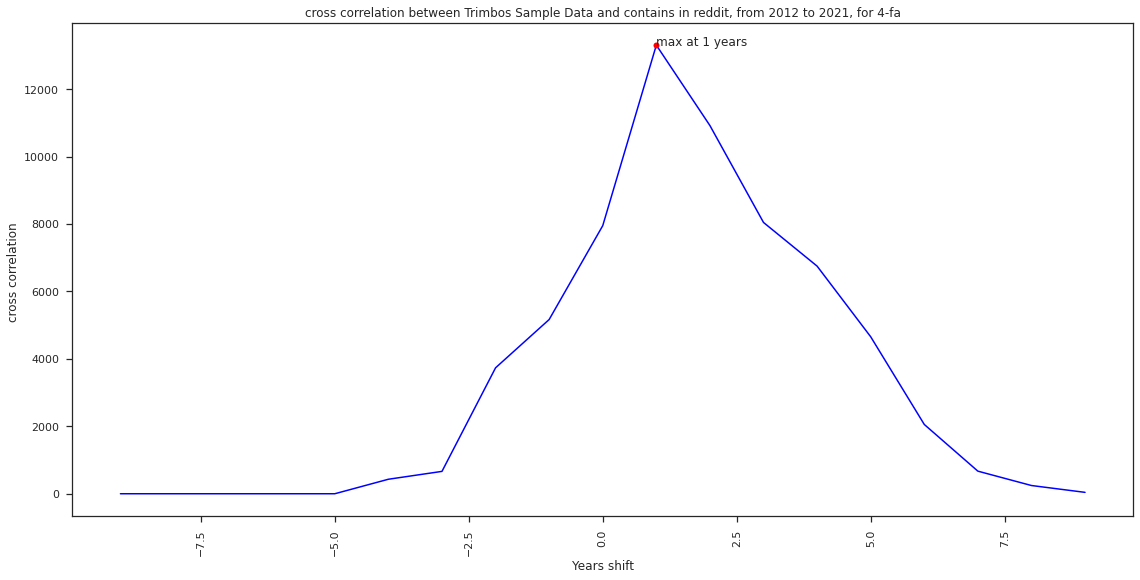

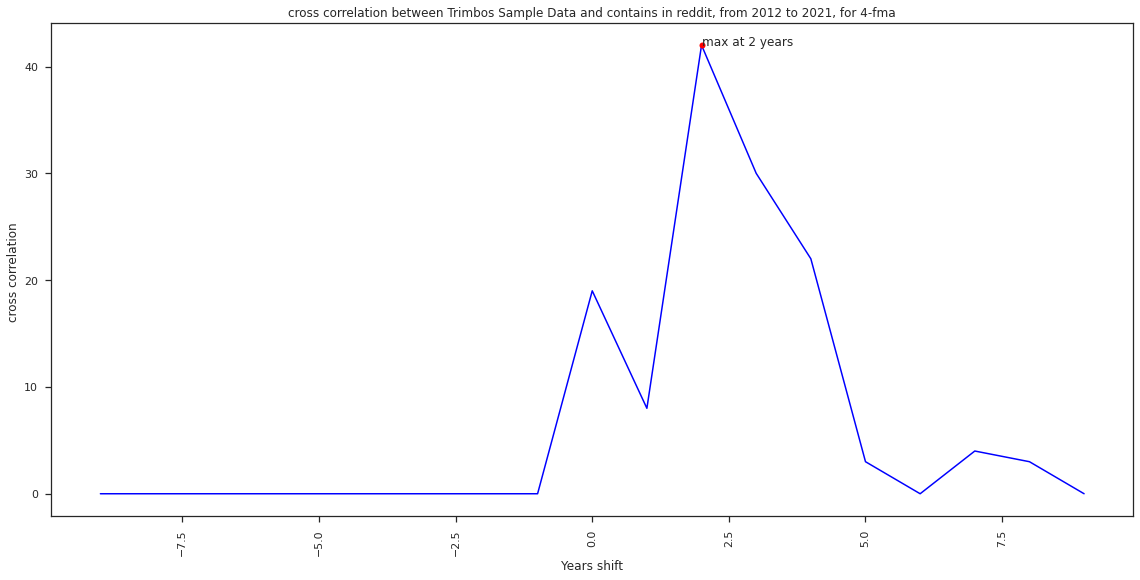

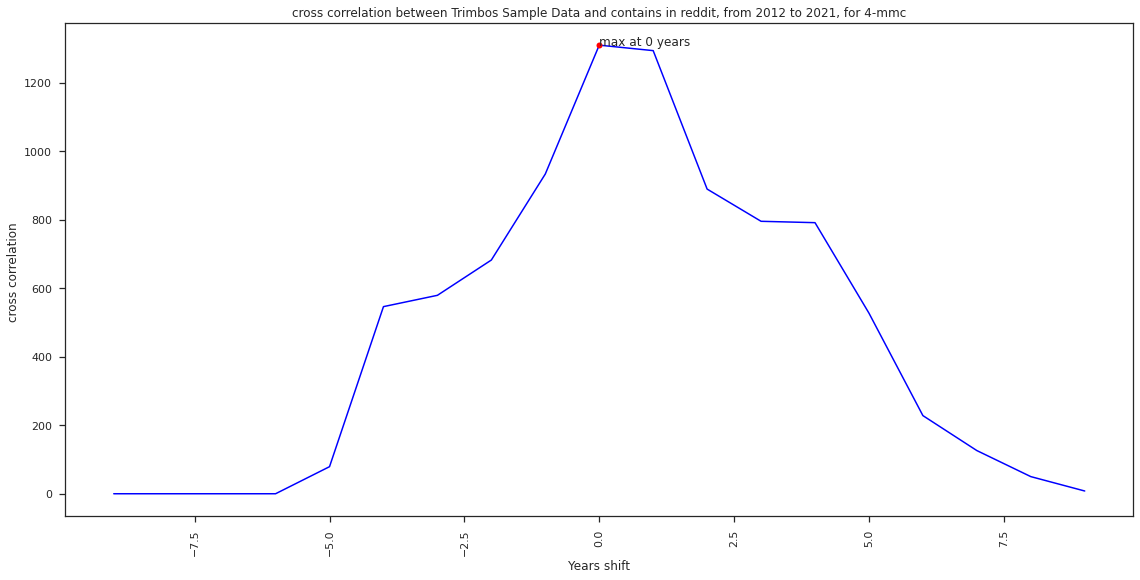

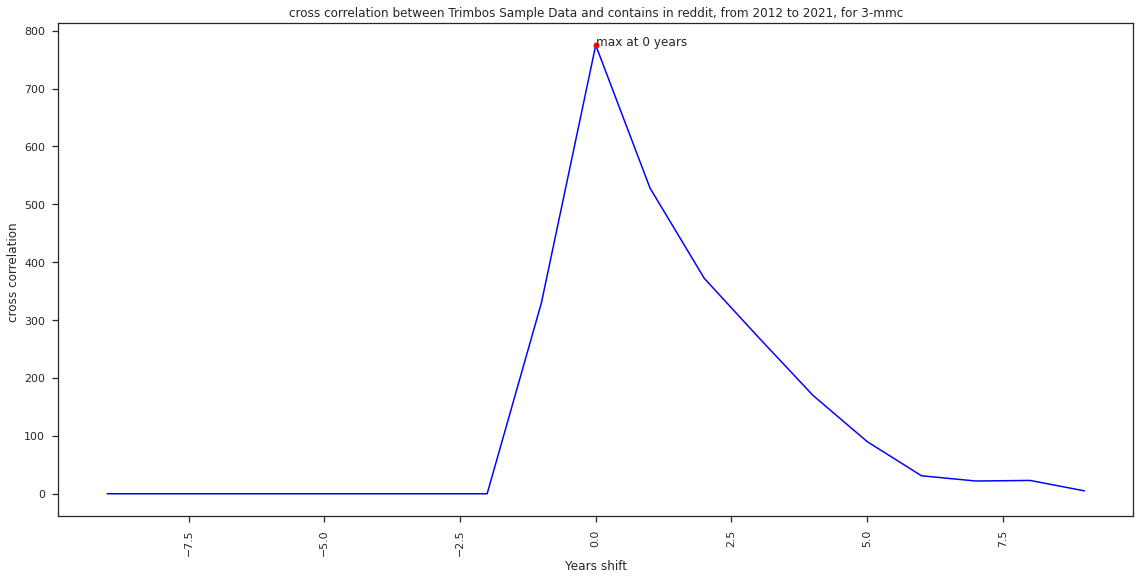

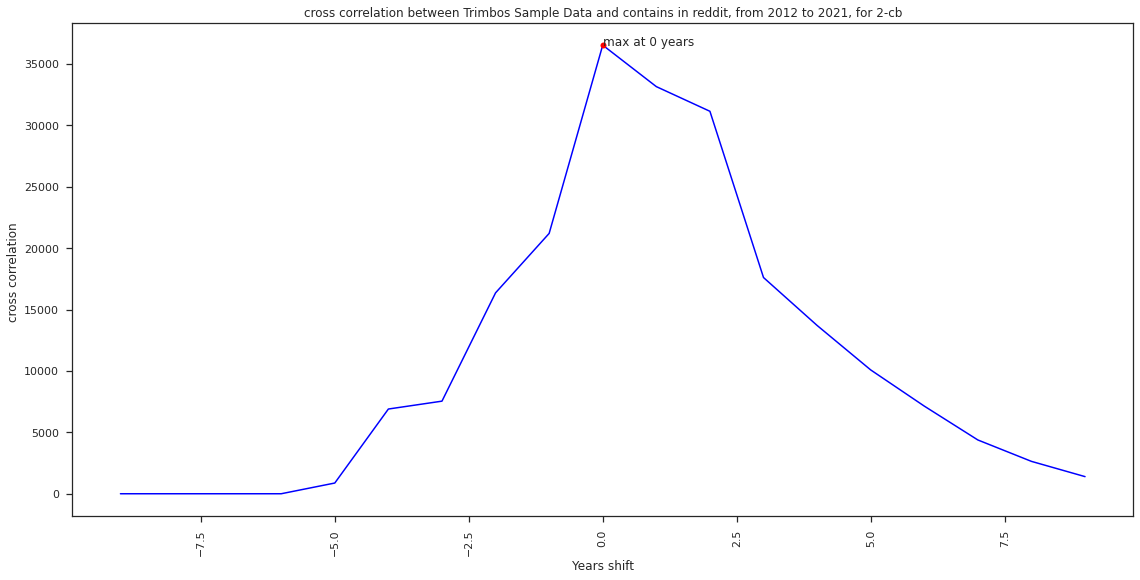

In [61]:
#Cross correlation
# import numpy as np

from scipy import signal



for i, drug in enumerate(search_drugs):
    search_mentions(data_combined_with_delta, drug_name=function_find_pattern(drug, drug_kwrds) )
    data_no_comments = data_combined_with_delta[data_combined_with_delta['kind']=='t3'].reset_index()
    
    for metrics in ['contains']:
     
        field_name = metrics +'_'+drug

        data_no_comments[field_name] = data_no_comments[metrics]*data_no_comments['contains'].astype('float')

        X = data_no_comments[['year', field_name]].groupby('year').sum()
        
        data = pd.DataFrame()
        data['trimbos'] = trimbos[drug]
        data['year'] = trimbos['year']
        data = data.merge(X, left_on='year', right_on='year')
        
        corr = signal.correlate(data[field_name], data['trimbos']) 
        lags = signal.correlation_lags(len(data[field_name]), len(data['trimbos']))

#         corr /= np.max(corr)
        fig, ax = plt.subplots()
        ax.plot(lags, corr, label='reddit', linewidth = 1.5, color='blue')
        plt.xticks(rotation='vertical') 
        arg_max = corr.argmax()
        ax.plot(lags[arg_max], corr[arg_max],'o', color='red')
        ax.text(lags[arg_max], corr[arg_max],f'max at {lags[arg_max]} years')
        ax.set(xlabel='Years shift')
        ax.set(ylabel= 'cross correlation ')

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.title("Cross correlation between Trimbos Sample Data and amount of "+ metrics +" in reddit, from 2012 to 2021, for "+ drug)
        plt.show()

0
